![header](img/Header.jpg)

# COPERNICUS MARINE WAVE NWS TRAINING (3/3)

<div style="text-align: right"><i> 04-03-WAV </i></div>

***

<center><h1>Analysing sea-states - Example from deterministic model data (Storm Dennis)</h1></center>


***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents

- [1. Introduction](#intro)
- [2. Setting-up the environment](#env)
- [3. Sea-state probability forecast](#seastateProb)
    - [3.1. Setting environment for probability](#seastateProb1)
    - [3.2.Compute sea-state probabilities](#seastateProb2)
    - [3.3. Compute most likely condition and associated probability](#seastateProb3)
- [4. Rapid sea-state change - probability of rapid change](#rapidSeastate)
- [5. Large waves and small vessels - probability to encounter a particular wave, f(hs max, wave steepness)](#largeWavesVessels)
- [6. Crossing Seas - probability of rough or greater crossed-seas](#crossedSeasProb)
- [7. Summary of sea-states during storm Dennis](#summary)
- [8. References](#ref)
***

<div class="alert alert-block alert-warning">
    
**This is part III**

If you want, you can go to:
    
- [Part I](04-01-NWS-WaveData-loader.ipynb) : Loading wave data and examples of visualization   
- [Part II](04-02-NWS-WaveData-seaSatesEx1.ipynb) : Analysing sea-states - Example from deterministic model data (Storm Xaver) 

# 1. Introduction <a class="anchor" id="intro"></a>
[Go back to the "Table of contents"](#Table-of-contents)

This notebook is provided as a suplementary example to [Part 2](04-02-NWS-WaveData-seaSatesEx1.ipynb): "04-02-NWS-WaveData-seaSatesEx1.ipynb" practical session. The present notebook follows the same steps than those mentioned in the practical session but now using <b>analysis-forecast data</b> and not re-analysis.

Hence, this notebook shows examples of generating sea-state and dangerous wave conditions forecasts.

In this example we will examine the 24 hours period from 00:00Z to 23:00Z on 15th February 2020 during which storm Dennis affected the NWS domain.

Remember we can use code from the `seastates` and `moplot_seastates` libraries supplied alongside this notebook.

# 2. Setting-up the environment <a class="anchor" id="env"></a>
[Go back to the "Table of contents"](#Table-of-contents)

Standard first step below to import the necessary modules.

In [1]:
# import standard libraries
import datetime
import numpy
import matplotlib.pyplot
import sys
import os

# setting-up the paths
root_dir = os.getcwd()
print(root_dir)

# insert path where the local library is located
sys.path.insert(0,root_dir)
#sys.path.insert(1, root_dir)

# import local library
import wavetools.seastates.seastates as sst
import wavetools.seastates.moplot_seastates as mopst
import wavetools.loaders.read_CMEMS_wave as rdwv

# set the local data directory
datadir = os.path.join(root_dir,'data')

# set out_dir to save the plots
outdir = os.path.join(root_dir,'img/04_03')

/DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products


Firstly we need to load in some data; in the example below this will use the NWS analysis/forecast product (1hourly temporal resolution) for waves.

We will need to point the code at files that have been downloaded from CMEMS. The next section of code simply sets the data directory where the files are stored and the analysis/cycle time associated with the files (this is the YYYYMMDD string following the letter 'b' in the file name).

Another main difference between this example and [Part 2](04-02-NWS-WaveData-seaSatesEx1.ipynb): "04-02-NWS-WaveData-seaSatesEx1.ipynb" practical session is that here we use modules provided with these notebooks to load and read the wave products (`wavetools.loaders.read_CMEMS_wave`), whereas in the practical session we used standard libraries such as xarray. 


In [2]:
# set year, month and day for the analysis cycle
# NOTE: at present the model cycles once per day, so hour is always set to zero (UTC)
#storm dennis - analysis data
year=2020
month=2
day=16
# downloaded file is the analysis from 16/02/2020, i.e. fields from the 15th
# so forecast day is set to -1
fcday=-1
cycle = datetime.datetime(year,month,day,0)
cycstr = cycle.strftime('%Y-%m-%d %H%MZ')
print('[INFO] Product cycle time set to %s' %cycstr)

# generate an NWS filename based on cycle time and which analysis/forecast day we want (range[-1,5])
ncfile = rdwv.genfilename(cycle,fcday=fcday,datadir=datadir)

# get the content of the chosen netCDF file
rdwv.contentWaveCMEMS(ncfile)

[INFO] Product cycle time set to 2020-02-16 0000Z
[INFO] Reading content of file: /DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
title: hourly-instantaneous wave
source: Met Office Operational Suite, Atlantic Margin Model (AMM15S 3-1.5km) WAVEWATCH III
analysis/cycle time: 2020-02-15 00:00:00
---
Variables in file:
longitude : longitude
latitude : latitude
time : time
forecast_period : forecast period
forecast_reference_time : forecast reference time
VHM0 : Spectral significant wave height (Hm0)
VTM02 : Spectral moments (0,2) wave period Tm02
VTM10 : Spectral moments (-1,0) wave period (Tm-10)
VTPK : Wave period at spectral peak / peak period (Tp)
VMDR : Mean wave direction from (Mdir)
VPED : Wave principal direction at spectral peak
VHM0_WW : Spectral significant wind wave height
VHM0_SW1 : Spectral significant primary swell wave height
VHM0_SW2 : Spectral significant secondary swell wave height
VM

Now we can set a forecast leadtime to work with. At the Met Office, shipping forecast terminology is associated with specific leadtime ranges which (along with some other options) are defined and can be inspected from the `seastates` library. Hence, the forecast time terms (time in hours) are:

    'Imminent'      = [0,6],
    'Soon'          = [6,12],
    'Later'         = [12,24],
    'Tomorrow'      = [24,48],
    'Day 2 Outlook' = [48,72],
    'Day 3 Outlook' = [72,96],
    'Day 4 Outlook' = [96,120],
    'Day 5 Outlook' = [120,144],
    'Today'         = [0,23] for analysing 00-23Z on a given day, and
    'Yesterday'     = [-24,-1] for analysing 00-23Z on previous day, e.g. CMEMS analysis-forecast data.

In [3]:
defleadtimes = sst.set_leadtimes()
print(defleadtimes)

OrderedDict([('Imminent', [0, 6]), ('Soon', [6, 12]), ('Later', [12, 24]), ('Tomorrow', [24, 48]), ('Day 2 Outlook', [48, 72]), ('Day 3 Outlook', [72, 96]), ('Day 4 Outlook', [96, 120]), ('Day 5 Outlook', [120, 144]), ('Today', [0, 23]), ('Yesterday', [-24, -1])])


# 3. Sea-state probability forecast <a class="anchor" id="seastateProb"></a>

[Go back to the "Table of contents"](#Table-of-contents)

In this first example the plan is to generate sea-state probability information and then find the most likely case, based on significant wave height (Hs) occurrence probability. This will use a given sea-state scale (Douglas or Beaufort, in the library `douglas` and `beaufortsea`, respectively) with the input variable for significant wave height set using the CMEMS variable name 'VHM0'. If instead of sea-state we want to assess wind speed (Wspd) occurrence we need to use Beaufort scale (`beaufort` in the seastates library).

As an example for sea-state scale, we present Douglas scale as follows:

        'Calm (glassy)'  = [0.00,0.01],
        'Calm (rippled)' = [0.01,0.10],
        'Smooth'         = [0.10,0.50],
        'Slight'         = [0.50,1.25],
        'Moderate'       = [1.25,2.50],
        'Rough'          = [2.50,4.00],
        'Very Rough'     = [4.00,6.00],
        'High'           = [6.00,9.00],
        'Very High'      = [9.00,14.00], and
        'Phenomenal'     = [14.00,50.0].

We also need to set a leadtime for the analysis. In this example we will choose the period `Later` (12 to 24 hours) in order to set our forecast range.

### 3.1. Setting environment for probability <a class="anchor" id="seastateProb1"></a>

In [4]:
# set the sea-state scale to be used and associated wave variable

# option for douglas sea-state
scale = 'douglas'
varname = 'VHM0'

# option for beaufort sea-state
#scale = 'beaufortsea'
#varname = 'VHM0'

# set the probability type to be used
probability_type = 'occur'

# set a leadtime for the analysis
timename = 'Later'
leadtimes = defleadtimes[timename]


Once the cycle, leadtime and relevant variable for analysis selected, the data can be loaded using the `read_CMEMS_wave` library (provided with this notebook) into a variable class, which contains the required field data, plus ancillary information (time, latitude, longitude etc).

[INFO] Reading all time indices from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Loading VHM0 data from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc

hs is a python object with the following keys:
dict_keys(['var', 'longname', 'standard', 'glats', 'glons', 'times', 'fcref', 'fclead', 'data', 'units'])
array shape for data loaded into var is as follows:
(24, 1240, 958)


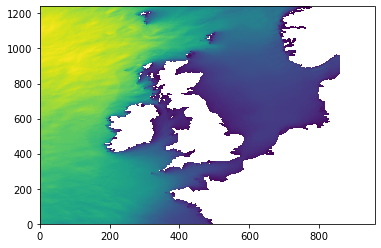

In [5]:
# retrieve variables for analysis from the NWS shelf product file(s)
hs = rdwv.readWaveCMEMS(varname, filename=ncfile, datadir='')

# hs is a class for the loaded data - show the available attributes
print()
print('hs is a python object with the following keys:')
print(hs.__dict__.keys())
# print the shape of the loaded data [t,y,x]
print('array shape for data loaded into var is as follows:')
print(numpy.shape(hs.data))

# plot the variable
matplotlib.pyplot.pcolormesh(hs.data[0,:,:])

# save the plot
out_name = os.path.join(outdir,'04_03_'+varname+'_testing.png')
matplotlib.pyplot.savefig(out_name,bbox_inches="tight", pad_inches=0.1, dpi=150)

### 3.2. Compute sea-state probabilities <a class="anchor" id="seastateProb2"></a>
Now that the significant wave height data is loaded, we can assess the occurrence probabilities for all sea-states within the prescribed time window ('Later' for this example) and using a particular scale ('douglas' for this example). We use `sst.seastatesP()` function in order to compute sea-state probabilities. Inputs for this function are:
 
* hs: input wave height or wind speed field
* scale: seastate/wind category scale (see set_seastates; douglas' and 'beaufortsea' for hs; 'beaufort' for wspd)
* ptype: probability type; 'occur' (default) is probability of event in population, 'encounter' is probability event that is encountered in sample

[INFO] Setting analysis scale to: douglas
[INFO] Testing a 3D (t,x,y) array
[INFO] Probability type is occur
[INFO] Testing for Calm (glassy)
[INFO] Testing for Calm (rippled)
[INFO] Testing for Smooth
[INFO] Testing for Slight
[INFO] Testing for Moderate
[INFO] Testing for Rough
[INFO] Testing for Very Rough
[INFO] Testing for High
[INFO] Testing for Very High
[INFO] Testing for Phenomenal
[INFO] Calling the plotting routine


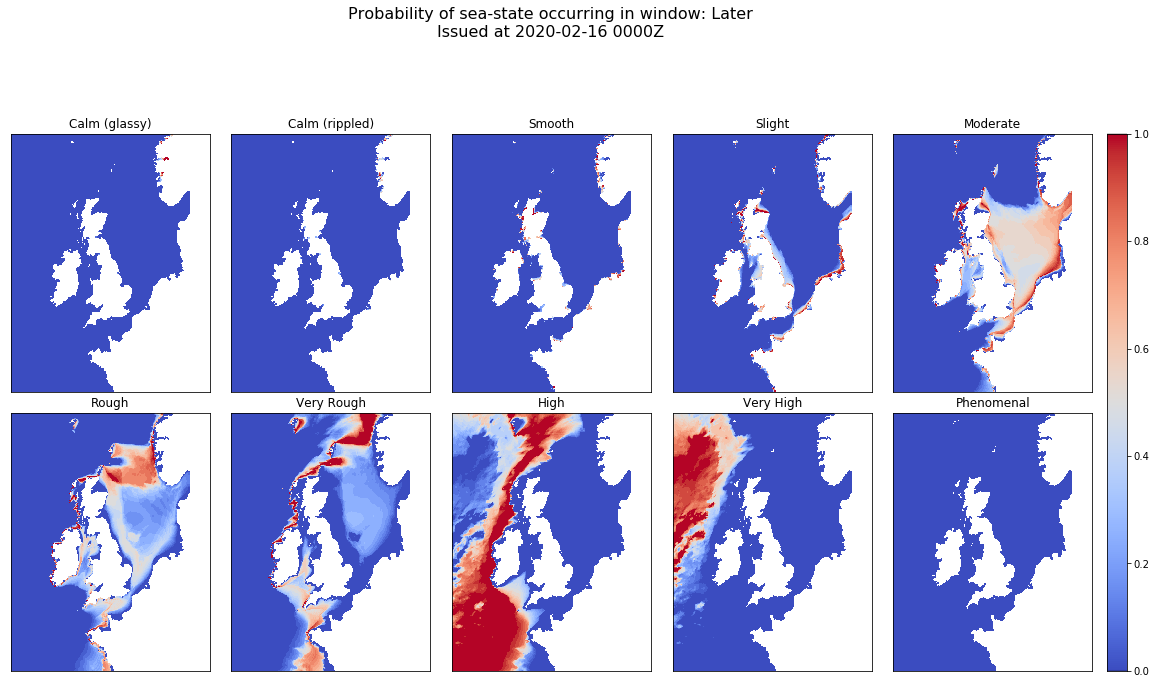

In [6]:
# calculate sea-state probabilities
# outputs are:
# defseastates - a definition list for the sea-state scale we are using
# pseastates - array of probabilities for each of the defined sea-states
defseastates, pseastates = sst.seastatesP(hs.data, scale=scale, ptype=probability_type)

# plot the sea-state probabilities
print('[INFO] Calling the plotting routine')
mopst.plot_pseastates(defseastates, pseastates, timename, cycstr=cycstr, scale=scale, show=True, save=True, savedir=outdir)


### 3.3. Compute most likely condition and associated probability <a class="anchor" id="seastateProb3"></a> 
From the pseastates data, which is basically an array of probabilities for each sea-state category, the most likely sea-state (i.e. the condition with the highest probability of occurrence) can also be established. For this, we run the `sst.seastate_from_pseastates()` function, which uses the array of probabilities for each of the defined sea-states `pseastates`.

In the plots generated using the code below, both the most likely condition and its associated probability are shown; the probability gives a forecaster some idea of the certainty they can associate with a deterministic forecast based purely on the most likely case.

[INFO] Calling the plotting routine
[INFO] Setting analysis scale to: douglas


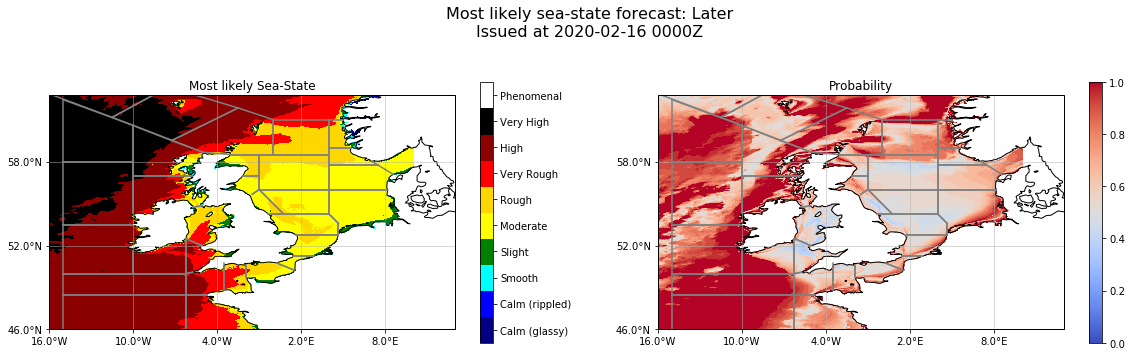

In [7]:
# calculate most likely sea-state
# outputs are:
# mlseastate - array of most likely sea-states
# cpseastate - probability associated with most likely sea-state
mlseastate, cpseastate = sst.seastate_from_pseastates(pseastates)

# plot the most likely sea-state and associated probability and overlay Met Office shipping forecast areas
print('[INFO] Calling the plotting routine')
mopst.plot_mlseastates(hs.glats, hs.glons, mlseastate, cpseastate=cpseastate, timename=timename, 
                       cycstr=cycstr, scale=scale, shipareas=True, usemap=True, show=True, save=True, savedir=outdir)


Plots include Met Office shipping and high seas areas as defined in the `wavetools.seastates.set_shippingareas()` function.

# 4. Rapid sea-state change - probability of rapid change <a class="anchor" id="rapidSeastate"></a>
[Go back to the "Table of contents"](#Table-of-contents)

A further test that can be made with wave height (sea-state) information only is to check whether the waves will increase rapidly during the forecast window. Here we follow the analysis suggested by Toffoli (2005), looking at 20% increases in wave height within a 6-hour time window.These windows are defined as follows:

* For hourly data, each 6 hour window is defined as six steps, i.e. hours 0,1,2,3,4,5.
* For 3-hourly data, the same 6 hour window would be defined assuming that hour 0 represents hours 0,1,2; hour 3 represents hours 3,4,5; and so on.

In the example below, we continue to analyse the 24 hours of 15/02/2020, so will test 19 consecutive 6-hour windows. We use sst.deltaZ() function.

[INFO] Testing a 3D (t,x,y) array
[INFO] Probability type is occur
[INFO] Testing 19 windows of 6 hours
[INFO] Calling the plotting routine


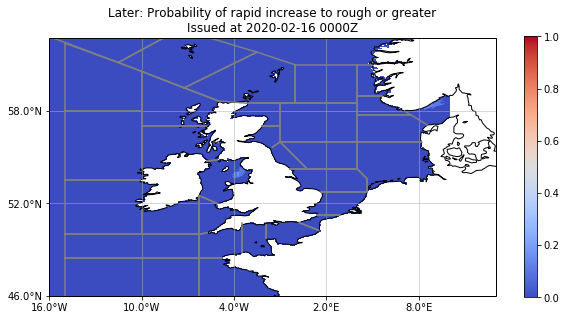

In [8]:
# run the pDeltaZ function, inputs are:
# hs - the input variable data
# thresh - the change we want to test against
# hsthresh - a background minimum we want the increased variable to exceed
# tdelta - the time window
# tstep - time, in hours, between data points
# ptype - the probability type being used (occur/encounter)

probability_type='occur'
pDeltaZ = sst.deltaZ(hs.data, thresh=0.2, hsthresh=2.5, tdelta=6.0, tstep=1.0, ptype=probability_type)

# set a title for the plot
if probability_type == 'encounter':
    eventtitle = ['pdeltaZ','encountering rapid increase to rough or greater']
else:
    eventtitle = ['pdeltaZ','rapid increase to rough or greater']
# plot the probability for rapid sea-state development and overlay Met Office shipping areas
print('[INFO] Calling the plotting routine')
mopst.plot_pfield(hs.glats, hs.glons, pfield=pDeltaZ, timename=timename, cycstr=cycstr, event=eventtitle, 
                   showzeros=True, shipareas=True, usemap=True, show=True, save=True, savedir=outdir)


# 5. Large waves and small vessels - probability to encounter a particular wave, f(hs max, wave steepness) <a class="anchor" id="largeWavesVessels"></a>
[Go back to the "Table of contents"](#Table-of-contents)

Sea-state is a relatively simple indicator of what can be quite a complex distribution of individual waves with different heights, periods and directions. Within a given sea-state it is therefore useful to understand the risk of encountering an individual wave which might put a vessel at risk.

This analysis calculates the encounter probability for individual high and steeps waves, i.e. the chance of a vessel experiencing such a wave if it was on site for the duration of the forecast window. In this case we focus on small vessels and define risk based on a wave height exceeding a specified threshold and with steepness greater than 1-in-8. The thresholds used are 3.6m and 7.2m, defining a capsize risk in beam-seas for small vessels at length 12m and 24m respectively. In addition, the 7.2m threshold defines a risk of swamping for the 12m vessel in head/following seas.

In order to generate the estimates of individual wave height exceedence probabilities and calculate steepness, this analysis needs to load an estimate of wave period in addition to significant wave height. Here we use the mean zero-upcrossing period or $T_z$ (VTM02).

From Forristall, G.Z. (1978) we know that the probability of a normalized wave height exceeding a given threshold $x$ is:

<center>$E(x)$ = $exp$ (-$x^{\\alpha}$/$\\beta$)</center>

with $\\alpha$ = 2.126 and $\\beta$ = 8.42. 

Hence, the probability distribution function that a height $X$ will be less than $x$ is 

<center>$F_x(x)$ = 1 - $E(x)$</center>

Additionally, waves steepness ($steepness$) is computed following the form:

<center>$steepness$ = 2$\\pi$ $H_s$/9.81 $T_z^2$</center>


[INFO] Reading all time indices from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Loading VHM0 data from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Reading all time indices from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Loading VTM02 data from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Testing a 3D (t,x,y) array
[INFO] Probability type is encounter
[INFO] Including calculation of Hmax breaking wave probability
[INFO] Calling the plotting routine


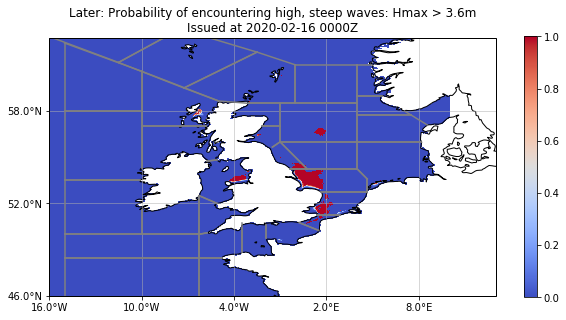

[INFO] Testing a 3D (t,x,y) array
[INFO] Probability type is encounter
[INFO] Including calculation of Hmax breaking wave probability
[INFO] Calling the plotting routine


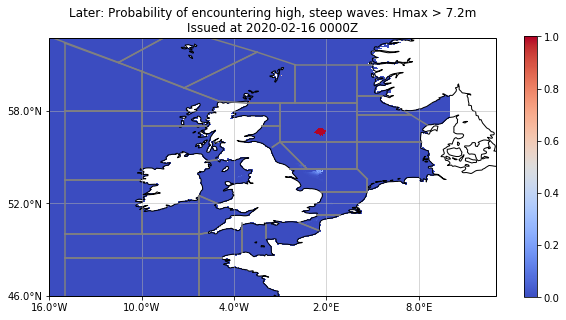

In [9]:
# set the probability type
probability_type='encounter'

# retrieve hs and tz variables for analysis from the NWS shelf product file(s)
hs = rdwv.readWaveCMEMS('VHM0', filename=ncfile, datadir='')
tz = rdwv.readWaveCMEMS('VTM02', filename=ncfile, datadir='')

# run the analysis and plotting routines

# first step is to set the number of waves encountered in each forecast time-step 
# (e.g. 1 hour for the NWS analysis/forecast products)
numwaves = sst.numWaves(tz.data)# not necessary to include the window (in seconds) as one-hourly is the default window in the function

# second, analyse probability of encounter a high, steep wave
# Calculate probability of encountering an extreme wave of height h within a sea state hs of n waves
# Inputs:
#    h - threshold wave height for individual wave
#    hs - background sea-state
#    numwaves - number of waves encountered in sample period
#    rayleigh - uses Rayleigh settings in Hmax calcs (default is Forristall)
#    ptype: probability type; occur (default) is probability of event in population, encounter is 
# probability event is encountered in sample
#    tsteep: include period data in order to check whether waves are close to breaking seas limit

# analysis/plotting loops over the 3.6 and 7.2m thresholds
for hmax in [3.6,7.2]:
    # analyse probability of a high, steep wave
    phmax = sst.hmaxP(hmax, hs.data, numwaves=numwaves, rayleigh=False, ptype=probability_type,
                      tsteep=tz.data, slim=0.125)
    
    # third, set a title for the plot
    if probability_type == 'encounter':
        eventtitle = ['phmax%.1fm' %hmax,'encountering high, steep waves: Hmax > %.1fm' %hmax]
    else:
        eventtitle = ['phmax%.1fm' %hmax,'high, steep waves occurring: Hmax > %.1fm' %hmax]
    # fourth, plot the probability map and overlay Met Office shipping forecast areas
    print('[INFO] Calling the plotting routine')
    mopst.plot_pfield(hs.glats, hs.glons, pfield=phmax, timename=timename, cycstr=cycstr, event=eventtitle, 
                       showzeros=True, shipareas=True, usemap=True, show=True, save=True, savedir=outdir)


# 6. Crossing Seas - probability of rough or greater crossed-seas <a class="anchor" id="crossedSeasProb"></a>
[Go back to the "Table of contents"](#Table-of-contents)

It is often the case that seas are not unimodal and, instead, comprise a local wind-sea plus one or more remotely generated swells. This can lead to complex wave fields that make seakeeping difficult and potentially hazardous.

The final analysis in this example uses the wave components provided in the NWS wave product; i.e. significant wave heights and directions for wind-sea, primary and secondary swell components to assess the probability that crossing-seas may be encountered during already challenging conditions when the sea-state is 'rough' or larger. 

*Remember that according to Douglas scale for hs, 'Rough' = [2.50,4.00].

Furthermore, for this last exercise we will use VHM0_WW, VMDR_WW, VHM0_SW1, VMDR_SW1, HM0_SW2 and VMDR_SW2. The computed crossed-sea probability is based on wave components and follows Kohno (2013) with direction separation of 30$^o$ and ratio of primary to secondary at 0.6.

[INFO] Reading all time indices from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Loading VHM0_WW data from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Reading all time indices from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Loading VMDR_WW data from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Reading all time indices from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_WAV_b20200216_hi20200215.nc
[INFO] Loading VHM0_SW1 data from //DATA/shared_trainers/training-NWS/04 Jupyter Notebook - Wave model Products/data/metoffice_wave_amm15_NWS_W

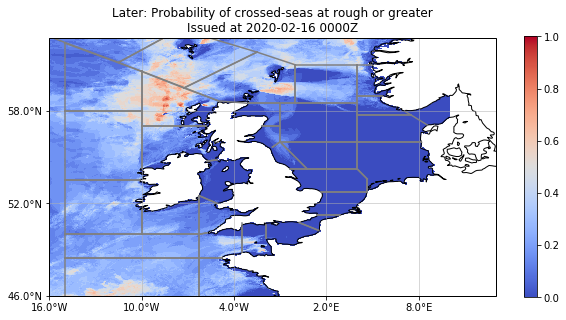

In [10]:
# set the probability type
probability_type='occur'

# retrieve hs and direction variables for analysis from the NWS shelf product file(s)
hsww = rdwv.readWaveCMEMS('VHM0_WW', filename=ncfile, datadir='')
dmww = rdwv.readWaveCMEMS('VMDR_WW', filename=ncfile, datadir='')
hssw1 = rdwv.readWaveCMEMS('VHM0_SW1', filename=ncfile, datadir='')
dmsw1 = rdwv.readWaveCMEMS('VMDR_SW1', filename=ncfile, datadir='')
hssw2 = rdwv.readWaveCMEMS('VHM0_SW2', filename=ncfile, datadir='')
dmsw2 = rdwv.readWaveCMEMS('VMDR_SW2', filename=ncfile, datadir='')

# run the analysis
pCrossSea = sst.crossSea([hsww.data,hssw1.data,hssw2.data], [dmww.data,dmsw1.data,dmsw2.data],
                         hsthresh=2.5, dthresh=30.0, cratio=0.6, ptype=probability_type)

# set a title for the plot
if probability_type == 'encounter':
    eventtitle = ['pCrossSea','encountering crossed-seas at rough or greater']
else:
    eventtitle = ['pCrossSea','crossed-seas at rough or greater']

# plot the probability map and overlay Met Office shipping forecast areas
print('[INFO] Calling the plotting routine')
mopst.plot_pfield(hsww.glats, hsww.glons, pfield=pCrossSea, timename=timename, cycstr=cycstr, event=eventtitle, 
                  showzeros=True, shipareas=True, usemap=True, show=True, save=True, savedir=outdir)


***
# 7. Summary of sea-states during Storm Dennis <a class="anchor" id="summary"></a>
[Go back to the "Table of contents"](#Table-of-contents)

<b><u>Exercise</u></b>

Where do we find high and greater sea-states? 
What is the most likely sea-state across the North Sea? And its associated probability?
Is there risk for small vessels?  
***

# 8. References<a class="anchor" id="ref"></a>

Forristall, G.Z., 1978: Statistical distribution of wave heights in a storm.  J. Geophys. Res., 83, 2353-2358.

Kohno, N. 2013: An approach for tough navigation sea information.  In Proc. 13th  International Workshop on Wave Hindcasting and Forecasting.

Toffoli, A., J. Lefèvre, E. Bitner-Gregersen, and J. Monbaliu, 2005: Towards the identification of warning criteria: Analysis of a ship accident database.  Appl. Ocean Res., 27, 281–291.

Zhang, Z. and Li,X.-M., 2017: Global ship accidents and ocean swell-related sea states. Nat. Hazards Earth Syst. Sci., 17, 2041–2051.